In [ ]:
import json
import os
from collections import defaultdict
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt

In [86]:
class Day:
    def __init__(self, file):
        self.file = file
        self.activities, self.skills = json.loads(self.file.read_text())


def checkAllElementsEqual(lst):
    return len(set(lst)) == 1


class Dataset:
    def __init__(self, days):
        self.days = days

    def getSkillExpLists(self, removeDeltaZero=False, minMaxToleranceGT=None):
        if removeDeltaZero:
            data = self.removeDeltaZero()
        else:
            out = defaultdict(list)
            for item in self.days:
                for skill in self.days[item].skills:
                    out[skill].append(int(self.days[item].skills[skill]["experience"]))
            data = dict(out)
        if minMaxToleranceGT is not None:
            data = self.removeMinMaxTollerance(data, minMaxToleranceGT)
        return data

    def removeMinMaxTollerance(self, ds, minMaxToleranceGT):
        keep = []
        for skill in ds:
            ma = max(ds[skill])
            mi = min(ds[skill])
            de = int(ma - mi)
            if de > minMaxToleranceGT:
                keep.append(skill)
        new_ds = {}
        for skill in keep:
            new_ds[skill] = ds[skill]
        return dict(new_ds)

    def getDays(self):
        return list(self.days.keys())

    def removeDeltaZero(self):
        values = defaultdict(list)
        for day in self.days:
            for skill in self.days[day].skills:
                values[skill].append(int(self.days[day].skills[skill]["level"]))
        keep = []
        for skill in values:
            if not checkAllElementsEqual(values[skill]):
                keep.append(skill)
        new_ds = {}
        for skill in keep:
            new_ds[skill] = values[skill]
        return dict(new_ds)


def getDataSet():
    paths = list(
        filter(None, [p if p.is_file() else None for p in Path("data").iterdir()])
    )
    paths = sorted(paths, key=os.path.getmtime)
    return Dataset(
        {
            datetime.strptime(f.name.replace(".json", ""), "%Y-%m-%d"): Day(f)
            for f in list(paths)
        }
    )

In [87]:
ds = getDataSet()
x = ds.getDays()

In [88]:
expandedDataset = ds.getSkillExpLists(removeDeltaZero=True, minMaxToleranceGT=3)
del expandedDataset["overall"]
expandedDataset

{'fletching': [59, 60, 60, 60, 60, 60, 60, 60, 60, 60, 63],
 'firemaking': [50, 52, 52, 52, 52, 52, 52, 52, 52, 52, 57],
 'crafting': [46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 50],
 'smithing': [79, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83],
 'mining': [83, 84, 85, 87, 87, 87, 87, 87, 87, 87, 87],
 'slayer': [1, 1, 1, 15, 15, 15, 15, 15, 15, 15, 15],
 'divination': [43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 48]}

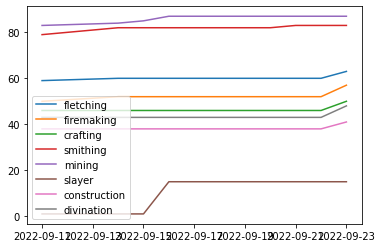

In [83]:
# Plot a simple line chart
for name in expandedDataset:
    l = expandedDataset[name]
    plt.plot(x, l, label=name)
# Plot another line on the same chart/graph
plt.legend(loc="lower left")
plt.savefig(f'charts/{datetime.now().date().strftime("%m-%d-%Y")}.png')

In [73]:
datetime.now().date().strftime("%m-%d-%Y")

'09-24-2022'